### Data Scraping

In [17]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [140]:
response = requests.get('http://www.worldbirdnames.org/master_ioc-names_xml.xml')
soup = BeautifulSoup(response.text, 'xml')
print(response.status_code)

speciesTree = []
for o in soup.find_all('order'):
    oname = o.find('latin_name').text
    for f in o.find_all('family'):
        fname = f.find('latin_name').text
        for g in f.find_all('genus'):
            gname = g.find('latin_name').text
            gAuthority = g.find('authority').text
            rank = 0
            for s in g.find_all('species'):
                rank +=1
                sname = s.find('latin_name').text
                toApp = [rank, oname, fname, gname, sname, gAuthority, s.find('authority').text, s.find('breeding_regions').text]
                speciesTree.append(toApp)

200


### Cleaning

In [141]:
def cleanNames(nameCol):
    toRet = []
    for n in nameCol:
        #print(n)
        n = n.replace(',', '')
        n = n.replace('& ', '')
        n = n.replace('et al', 'EtAl')
        n = n.strip()
        #print(n)
        toRet.append(n)
    return toRet

In [142]:
df = pd.DataFrame(speciesTree)
df.columns = ['Rank', 'Order', 'Family','Genus','Species','GAuth','SAuth','BreedRegion']

df['OrigG'] = [a.count(')') == 0 for a in df['SAuth']]
df['SAuth'] = df['SAuth'].str.replace( ')', '')
df['SAuth'] = df['SAuth'].str.replace( '(', '')

df['SDate'] = [int(a[-4:]) for a in df['SAuth']]
df['SAuthors'] = [ a[:-4] for a in df['SAuth']]

df['GDate'] = [int(a[-4:]) if a != 'E' else 1816 for a in df['GAuth'] ]
df['GAuthors'] = [a[:-4] if a != 'E' else 'Vieillot' for a in df['GAuth']]

df['SAuthors'] = cleanNames(df['SAuthors'])
df['GAuthors'] = cleanNames(df['GAuthors'])
df['BreedRegion'] = cleanNames(df['BreedRegion'])

df = df.drop(['GAuth','SAuth'], axis = 'columns')
df['DateRank'] = df.groupby('Genus')['SDate'].rank(ascending = True, method = 'min').astype(int)
#df['FullName'] = df['Order'] +' '+ df['Family']+' ' + df['Genus']+'_' + df['Species'].str[:-2]

spg = df.groupby('Genus')['Species'].count()
spg.name = 'SpG'

raw = df.merge(pd.DataFrame(spg), left_on= 'Genus', right_index= True)
#df.to_csv('SpGOrig.csv')

In [3]:
raw = pd.read_csv('SpGOrig.csv', encoding = 'ISO-8859-1', index_col = 0)

In [4]:
def addToNameDict(wds,MWNameDict):
    if len(wds) == 0:
        return None
    else:
        if wds[0] in MWNameDict:
            toPass = MWNameDict[wds[0]]
           
        else:
            toPass = {}
        MWNameDict[wds[0]] = addToNameDict(wds[1:], toPass)
        return MWNameDict

In [5]:
multiWordNames = ['zu Wied-Neuwied', 'Meyer de Schauensee', 'Barboza du Bocage',
                 'de Sélys-Longchamps', 'Du Bus de Gisignies',
                 'Gurney Sr', 'de Sparre', 'Gurney Jr',
                 'Xántus de Vésey', 'Da Silva Maia', 'de la Llave',
                 'de Filippi', 'Phelps Jr', 'Cardoso da Silva Novaes',
                 'Wetmore Phelps Jr', 'Giraud Jr', 'De Vis',
                 'De Roo', 'La Touche', 'Marshall JT Jr',
                 'de Tarragon', 'Phelps Jr', 'Le Maout',
                 'Raposo do Amaral']

In [6]:
MWND = {}
for n in multiWordNames:
    MWND = addToNameDict(n.lower().split(' '), MWND)

In [7]:
def authorSplit(ent):
    lst=[]
    spt = ent.split(' ')
    i = 0
    while i < len(spt):
        increment = 1
        
        if spt[i].isupper():
            prev = lst.pop()
            lst.append(' '.join([prev, spt[i]]).lower())
            
        elif (len(spt[i:])>1)&(spt[i].lower() in MWND):
            long = longName(spt[i:])
            lst.append(long)
            increment = len(long.split(' '))
                       
        else:
            lst.append(spt[i].lower())
        i+=increment
    return lst

def longName(nList):
    #print(nList)
    toRet = []
    more = MWND.copy()
    
    j = 0
    while more:
        
        toRet.append(nList[j].lower())
        if nList[j].lower() in more:
            more = more[nList[j].lower()]
        else:
            if j == 1:
                return nList[0]
            else:
                print('no')
        
        j+=1
    #print(' '.join(toRet))
    return ' '.join(toRet)

In [8]:
df = raw.copy()
df['SAuthors'] = df['SAuthors'].apply(authorSplit)
df['GAuthors'] = df['GAuthors'].apply(authorSplit)

In [9]:
df.head(20)

,Rank,Order,Family,Genus,Species,BreedRegion,OrigG,SDate,SAuthors,GDate,GAuthors,DateRank,SpG
0,1,STRUTHIONIFORMES,Struthionidae,Struthio,camelus,AF,True,1758,[linnaeus],1758,[linnaeus],1,2
1,2,STRUTHIONIFORMES,Struthionidae,Struthio,molybdophanes,AF,True,1883,[reichenow],1758,[linnaeus],2,2
2,1,RHEIFORMES,Rheidae,Rhea,americana,SA,False,1758,[linnaeus],1760,[brisson],1,2
3,2,RHEIFORMES,Rheidae,Rhea,pennata,SA,True,1834,[d'orbigny],1760,[brisson],2,2
4,1,APTERYGIFORMES,Apterygidae,Apteryx,australis,AU,True,1813,[shaw],1813,[shaw],1,5
5,2,APTERYGIFORMES,Apterygidae,Apteryx,mantelli,AU,True,1852,[bartlett],1813,[shaw],3,5
6,3,APTERYGIFORMES,Apterygidae,Apteryx,rowi,AU,True,2003,"[tennyson, palma, robertson, worthy, gill bj]",1813,[shaw],5,5
7,4,APTERYGIFORMES,Apterygidae,Apteryx,owenii,AU,True,1847,[gould],1813,[shaw],2,5
8,5,APTERYGIFORMES,Apterygidae,Apteryx,haastii,AU,True,1872,[potts],1813,[shaw],4,5
9,1,CASUARIIFORMES,Casuariidae,Casuarius,casuarius,AU,False,1758,[linnaeus],1760,[brisson],1,3


In [10]:
# Requires Raw Data

def authorCounts(data):
    SpAuths = data['SAuthors']
    GeAuths = data.groupby(['Genus'])['GAuthors'].unique()
    SpAuths = [authorSplit(e) for e in SpAuths]
    GeAuths = [authorSplit(e[0]) for e in GeAuths]
    
    def unlistAuthors(AList):
        ulAuths = []
        for lst in AList:
            for n in lst:
                ulAuths.append(n)
        ulAuths = pd.Series(ulAuths)
        ulAuths = ulAuths.value_counts()
        
        return ulAuths
    
    SpAuths = unlistAuthors(SpAuths)
    SpAuths.name = 'SpAuthored'
    GeAuths = unlistAuthors(GeAuths)
    GeAuths.name = 'GenAuthored'
    toRet = pd.concat([GeAuths, SpAuths], axis = 'columns')
    toRet.fillna(0, inplace  = True)
    for c in toRet:
        toRet[c] = toRet[c].astype(int)
    
    return toRet

In [11]:
cts = authorCounts(raw)
#cts.to_csv('authorship.csv')
spg = df.groupby(['SpG'])['Genus'].unique()
spg = spg.apply(len)
spa = cts['SpAuthored'].value_counts()
gpa = cts['GenAuthored'].value_counts()

spg = ('Species', 'Genus', spg)
spa = ('Species', 'Author', spa)
gpa = ('Genera', 'Author', gpa)

inspect module

In [12]:
def countPlotter(x,y,log = False):
    xticks = range(1,(int(max(y)/100)+1)*100+1,100)
    yticks = range(1,(int(max(x)/100)+1)*100+1, 25)
    
    if log:
        x = np.log(x)
        y = np.log(y)
        xticks = [np.log(t) for t in  xticks]
        yticks = [np.log(t) for t in yticks]
    plt.scatter(x,y)
    for t in xticks:
        plt.axhline((t), alpha = .1)
    for t in yticks:
        plt.axvline(t, alpha = .1)

def countPlotter2(x,y,rt = False):
    xticks = range(1,(int(max(y)/100)+1)*100+1,100)
    yticks = range(1,(int(max(x)/100)+1)*100+1, 25)
    if log:
        x = x**.25
        y = y**.25
        xticks = [(t)**.25 for t in  xticks]
        yticks = [(t)**.25 for t in yticks]
    plt.scatter(x,y)
    for t in xticks:
        plt.axhline((t), alpha = .1)
    for t in yticks:
        plt.axvline(t, alpha = .1)

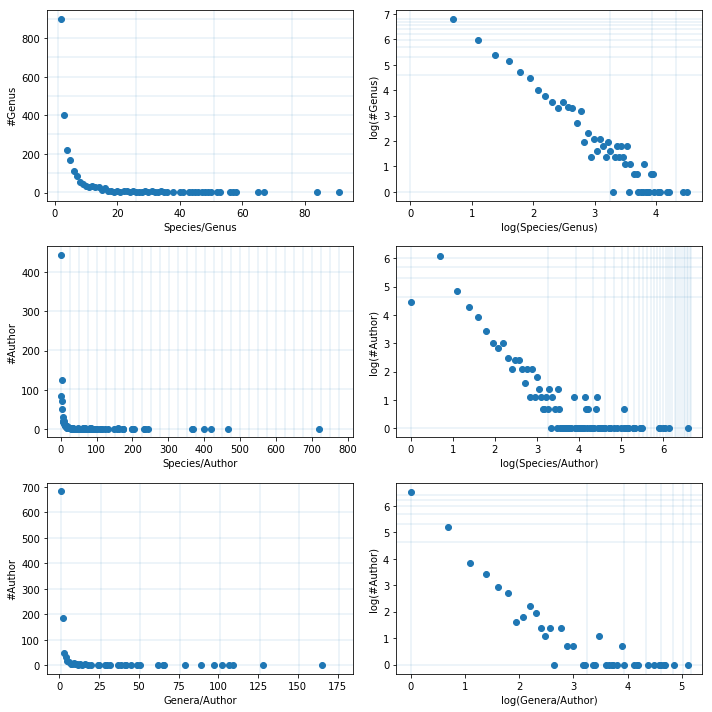

In [18]:
plt.figure(figsize = (10,10))
p = 0
for d in [spg, spa, gpa]:
    for log in [False, True]:
        p += 1
        plt.subplot(3,2,p)
        countPlotter(d[2].index+1, d[2].values, log)
        yl = '#' + d[1]
        xl = d[0] + '/' + d[1]
        if log:
            xl = 'log('+xl+')'
            yl = 'log('+yl+')'
        plt.xlabel(xl)
        plt.ylabel(yl)
plt.tight_layout()

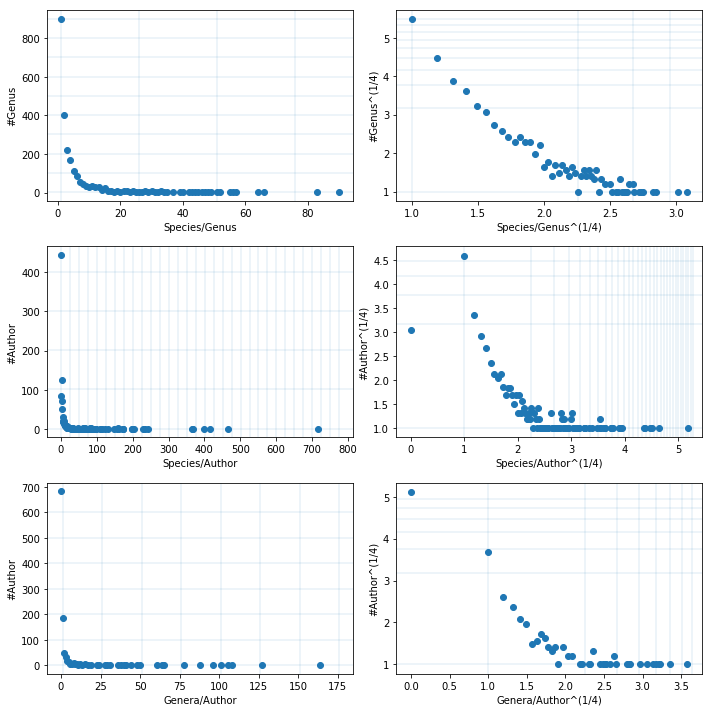

In [19]:
plt.figure(figsize = (10,10))
p = 0
for d in [spg, spa, gpa]:
    for log in [False, True]:
        p += 1
        plt.subplot(3,2,p)
        countPlotter2(d[2].index, d[2].values, log)
        yl = '#' + d[1]
        xl = d[0] + '/' + d[1]
        if log:
            xl = xl+'^(1/4)'
            yl = yl+'^(1/4)'
        plt.xlabel(xl)
        plt.ylabel(yl)
plt.tight_layout()

values = number of authors = Y  
index = species described = X

In [43]:
def randomizeRank(data):
    dfCollect = []
    for g in data['Genus'].unique():
        work = data[data['Genus'] == g].copy()
        work['Rank'] = np.random.permutation(range(1,len(work)+1))
        dfCollect.append(work)
    return pd.concat(dfCollect, axis = 'rows')

In [50]:
def alphaRank(data):
    dfCollect = []
    for g in data['Genus'].unique():
        work = data[data['Genus'] == g].copy()
        work = work.sort_values('Species')
        work['Rank'] = range(1,len(work)+1)
        dfCollect.append(work)
    return pd.concat(dfCollect, axis = 'rows')

In [60]:
%%time
dfp = df.drop(['Order', 'Family','BreedRegion','OrigG','GDate','GAuthors', 'SAuthors'], axis = 'columns')
randomR = randomizeRank(dfp)
alphaR = alphaRank(dfp)

Wall time: 11.8 s


In [61]:
realtabs = makeSpeciesRankDateTables(df)
randomtabs = makeSpeciesRankDateTables(randomR)
alphatabs = makeSpeciesRankDateTables(alphaR)

In [86]:
import seaborn as sns
from matplotlib import gridspec
import matplotlib.colors as colors

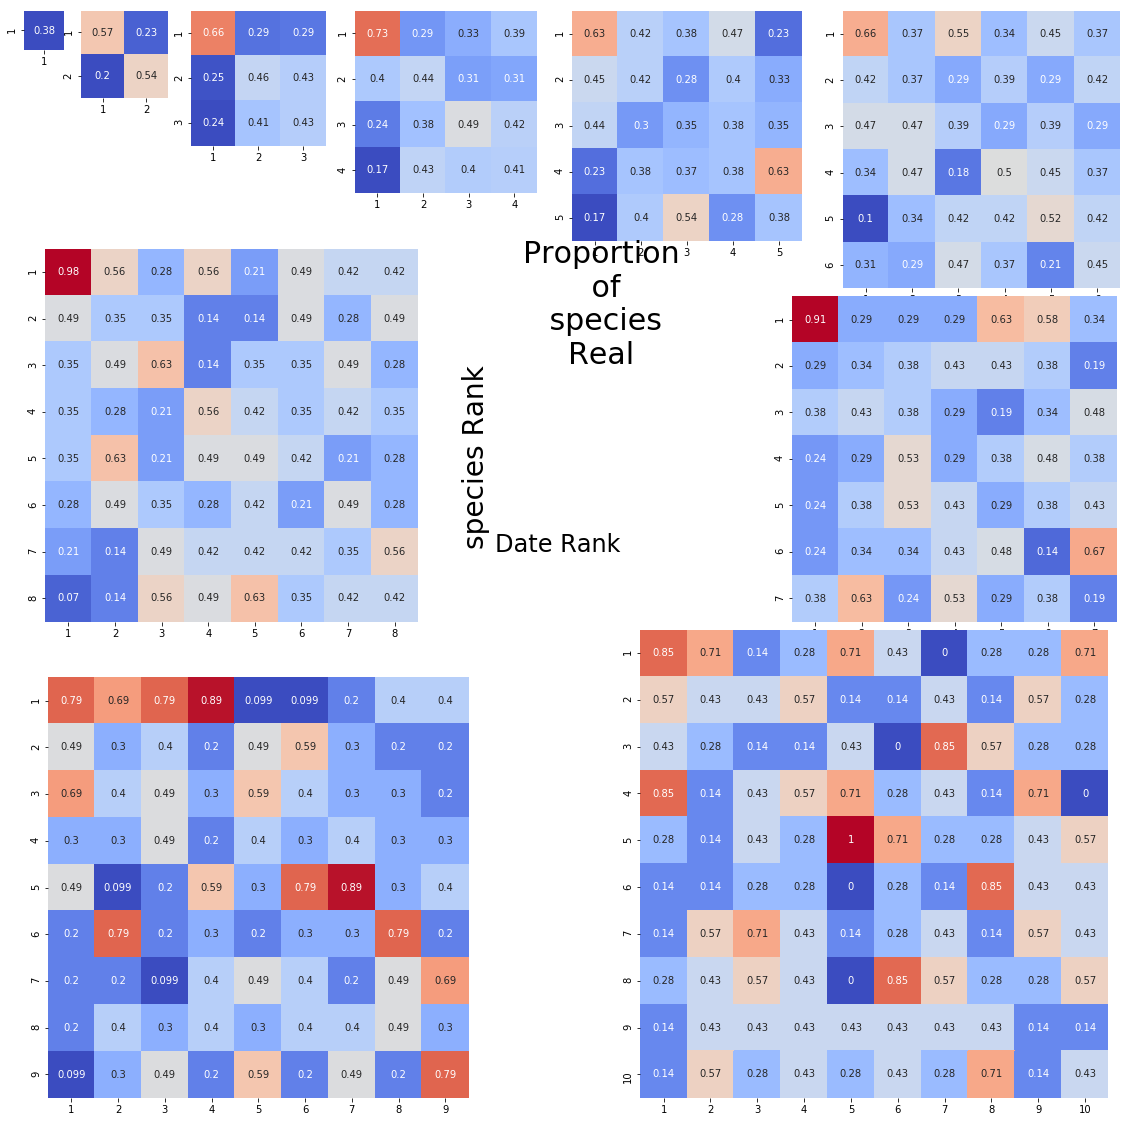

In [152]:
speciesRankDateHeat(realtabs, 'Real')

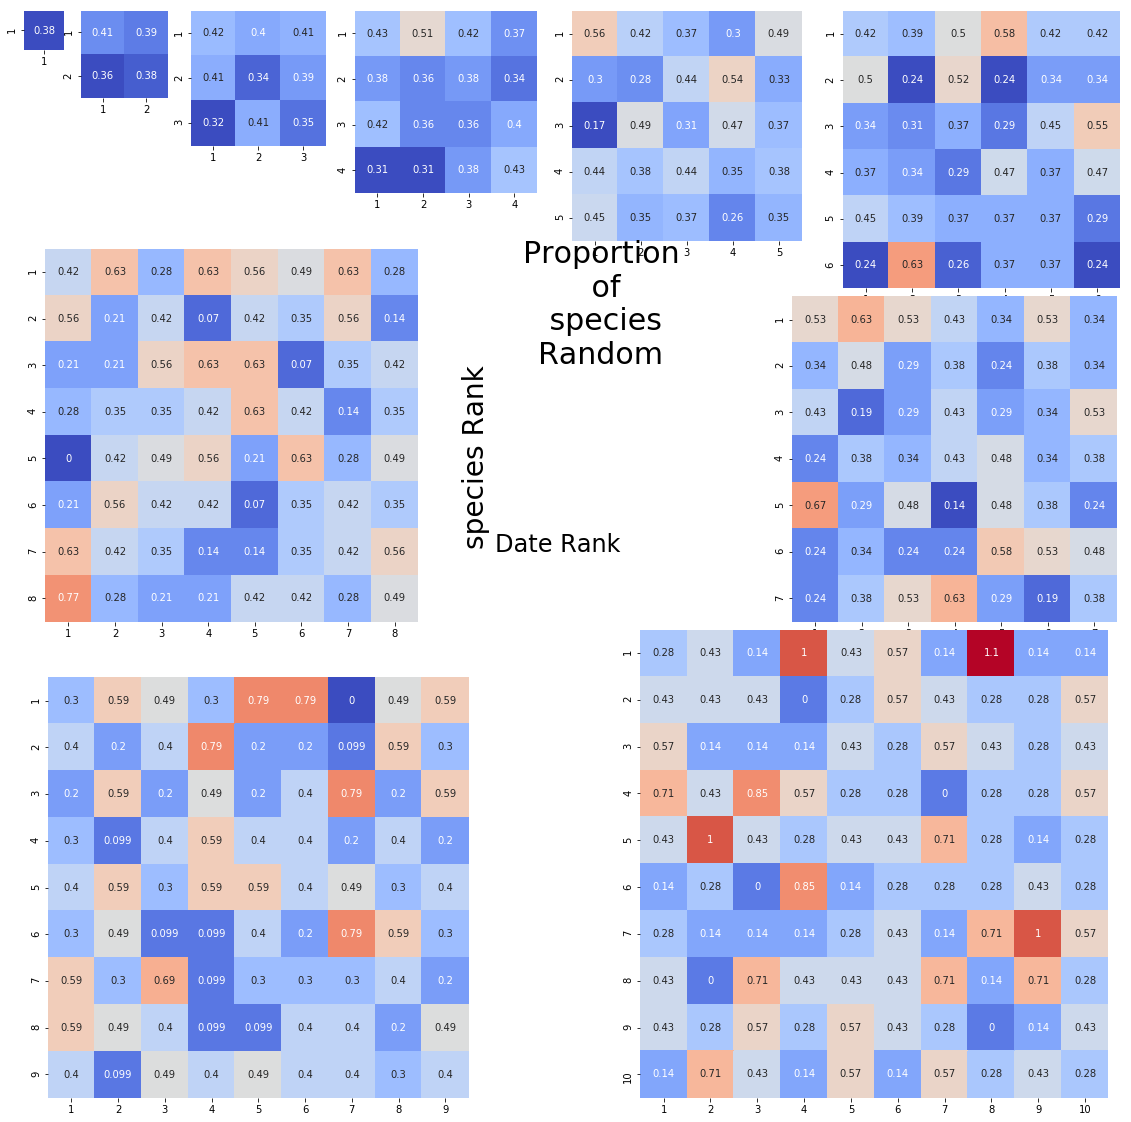

In [151]:
speciesRankDateHeat(randomtabs, 'Random')

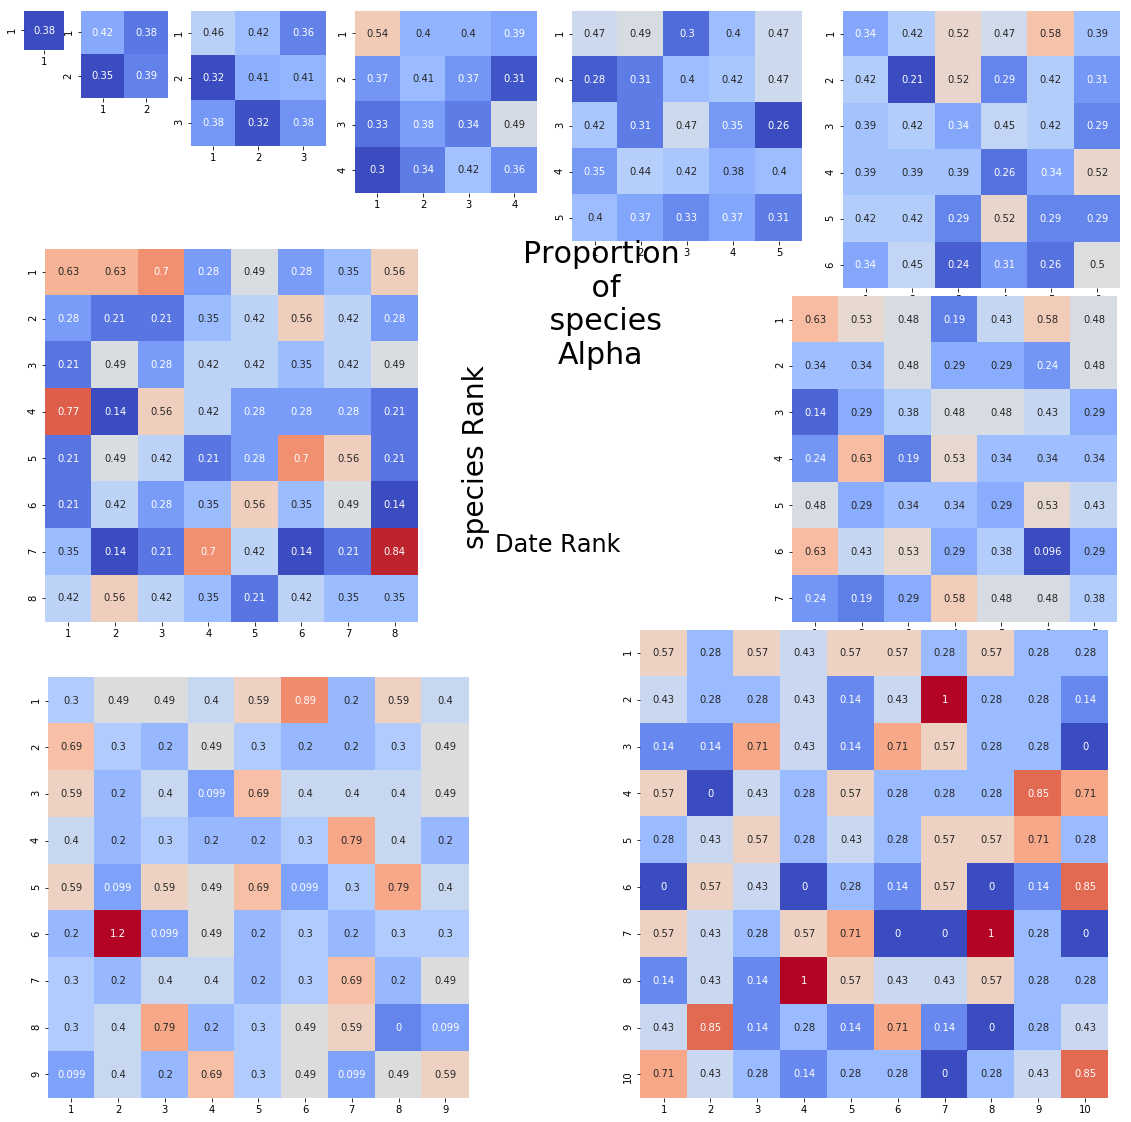

In [150]:
speciesRankDateHeat(alphatabs, 'Alpha')

In [146]:
def makeSpeciesRankDateTables(data):
    
    data = pd.DataFrame(data.groupby(['SpG','Rank', 'DateRank',])['Species'].count())
    
    tables = {}
    
    currentSPG = 0
    currentRank = 0
    prevDR = 0
    full = True
    
    for idx in data.index:
        
        # index in the format (species/genus, Rank, Date Rank)
        spg = idx[0]
        
        if spg >10:
            break
            
        rank = idx[1]
        dRank = idx[2]
        
        sp = data.loc[idx, 'Species']
        
        # If the s/G changes, create new list, reset counter variables
        if spg != currentSPG:
            if not full:
                while len(tables[currentSPG][currentRank]) < currentSPG:
                    tables[currentSPG][currentRank].append(0)
                    
            tables[spg] = {}
            currentSPG = spg
            tables[spg][rank] = []
            currentRank = 1
            prevDR = 0
            full = False
        
        # If rank changes, create new list, reset dateRank counter
        if rank != currentRank:
            if not full:
                while len(tables[currentSPG][currentRank]) < currentSPG:
                    tables[currentSPG][currentRank].append(0)
                    
            tables[spg][rank] = []
            currentRank = rank
            prevDR = 0
        
        # Check to see that current date rank is only one greater than previous
        # DateRank, if not, one was skipped, in which case zeros need to be added
        if prevDR +1 != dRank:
            for i in range(dRank-prevDR-1):
                tables[spg][rank].append(0)
        
        #append number of species
        tables[spg][rank].append(sp)
        full = len(tables[spg][rank]) == currentSPG
        prevDR = dRank
    return tables    

In [149]:
def speciesRankDateHeat(tables, title):
    locs = {1:(1,1),2:(1,2),3:(1,4),4:(1,7),5:(1,11),6:(1,16),7:(7,15),8:(6,1),9:(15,1),10:(14,12)}
    plt.figure(figsize = (20,20))
    
    i = 0
    for k in tables:
        i+=1

        temp = pd.DataFrame(tables[k])
        temp.index = range(1,len(temp)+1)
        
        for c in temp:
            temp[c] = [e/temp[c].sum()/(1/len(temp)) for e in temp[c]]
            temp[c] = [e/2.6 for e in temp[c]]
            
        where = locs[i]
        plt.subplot2grid((23,21),(where[0]-1, where[1]-1), colspan = i, rowspan = i)
        sns.heatmap(temp, annot = True, center = .5,
                    cmap = 'coolwarm', square = True, cbar = False)
    
    plt.subplot2grid((23,21),(5,8), colspan = 5, rowspan = 5)
    plt.axis('equal')
    plt.axis('off')
    
    plt.text(-0.05,-0.01,'species Rank', rotation = 'vertical', fontsize = 28)#, horizontalalignment = 'right')
    plt.text(-0.036,-0.08,'Date Rank', rotation = 'horizontal', fontsize = 24)#, horizontalalignment = 'left')
    plt.text(0.009,0.00,'Proportion\n of\n species\n'+title, fontsize = 30, horizontalalignment = 'center')

In [124]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Initial EDA

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [541]:
def plotSpg(data, num):
    df = data[data['SpG']==num]
    row = int(num/3)+1
    for i in range(1,num+1):
        #plt.figure(figsize = (10,8))
        plt.subplot(row,3,i)
        plt.hist(df[df['Rank'] ==i]['DateRank'])
        plt.title('Linear Rank = '+ str(i))
        plt.xlabel('Date-Rank')
        #plt.savefigfigfig(str(num) + '.png')
        #plt.ylim(ymax = 130)
        #plt.show()

In [ ]:
Sdfs = []
for n in range(1,11):
    Sdfs.append()

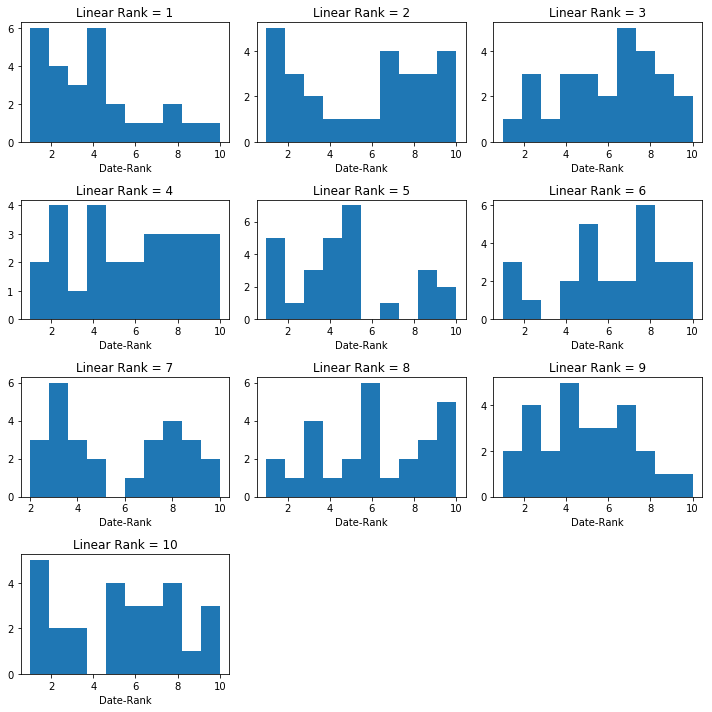

In [544]:
plt.figure(figsize = (10,10))
plotSpg(df, 10)
plt.tight_layout()

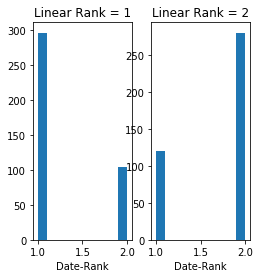

In [41]:
plotSpg(df,2)

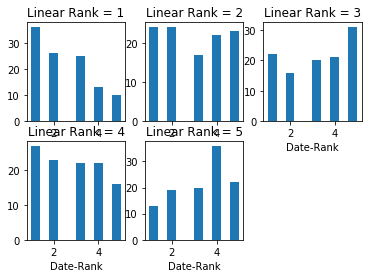

In [31]:
plotSpg(df, 5)

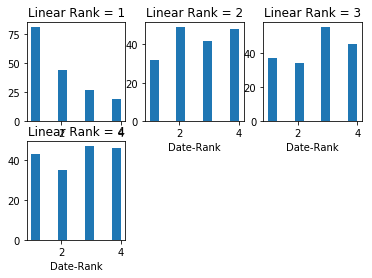

In [32]:
plotSpg(df, 4)

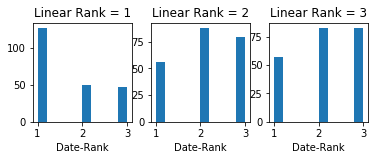

In [33]:
plotSpg(df, 3)

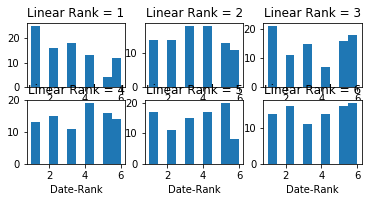

In [34]:
plotSpg(df, 6)

In [161]:
np.random.binomial(1,.4)

1

In [166]:
test = [0]
t2 = [test for i in range(10)]
t2

[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]

In [188]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [196]:
[0].append([2])

In [200]:
[2,3] == [2,3]

True

In [283]:
np.random.normal()

0.6591007834522732

In [273]:
import numpy as np
def simTree(generaNum, generations, split = .001, diffDist = np.random.normal, diffThresh = 2, starterVal = [0]):
    np.random.seed(1738)
    genera = [starterVal for i in range(generaNum)]
    
    for c in range(generations):
        #print(genera)
        for i, g in enumerate(genera):
            toAddInit = []
            toAddFin = []
            for sp in g:
                if np.random.uniform() > split:
                    
                    potentialS = diffDist(sp)
                    #print(potentialS)
                    different = True
                    for s in g:
                        #print(abs(s-potentialS))
                        if abs(s-potentialS) < diffThresh:
                            #print('here')
                            different = False
                            break
                            
                    if different:
                        toAddInit.append(potentialS)
                
            #print(toAddInit)
            if len(toAddInit) >1:
                for idx, pot in enumerate(toAddInit):
                    toAdd = True
                    for idx2 in range(idx, len(toAddInit)):
                        if abs(toAddInit[idx2] - pot) < diffThresh:
                            toAdd = False
                            break
                    if toAdd:
                        toAddFin.append(pot)
            else:
                toAddFin = toAddInit
            if toAddFin != []:
                #print('here2')
                toRep = g.copy()
                toRep.extend(toAddFin)
                genera[i] = toRep
    
    return genera

In [261]:
len(df['Genus'].unique())

2312

In [294]:
np.logspace(-1,-10)

array([  1.00000000e-01,   6.55128557e-02,   4.29193426e-02,
         2.81176870e-02,   1.84206997e-02,   1.20679264e-02,
         7.90604321e-03,   5.17947468e-03,   3.39322177e-03,
         2.22299648e-03,   1.45634848e-03,   9.54095476e-04,
         6.25055193e-04,   4.09491506e-04,   2.68269580e-04,
         1.75751062e-04,   1.15139540e-04,   7.54312006e-05,
         4.94171336e-05,   3.23745754e-05,   2.12095089e-05,
         1.38949549e-05,   9.10298178e-06,   5.96362332e-06,
         3.90693994e-06,   2.55954792e-06,   1.67683294e-06,
         1.09854114e-06,   7.19685673e-07,   4.71486636e-07,
         3.08884360e-07,   2.02358965e-07,   1.32571137e-07,
         8.68511374e-08,   5.68986603e-08,   3.72759372e-08,
         2.44205309e-08,   1.59985872e-08,   1.04811313e-08,
         6.86648845e-09,   4.49843267e-09,   2.94705170e-09,
         1.93069773e-09,   1.26485522e-09,   8.28642773e-10,
         5.42867544e-10,   3.55648031e-10,   2.32995181e-10,
         1.52641797e-10,

In [281]:
spParams =np.logspace(-1,-10)
diffTParam = np.linspace(.5,2.5)

In [297]:
time.time() - time.time()


0.0

In [295]:
import time

In [285]:
import pickle

spParams =np.logspace(-1,-10)
diffTParam = np.linspace(.5,2.5)
toRet = []

for sp in spParams:
    for dtP in diffTParam:
        print(dtP, sp)
        st = simTree(2000, 1000, split = sp, diffThresh= dtP)
        toRet.append((sp, dtP, [len(e) for e in st]))

with open('toRet.pickle','wb') as f:
    pickle.dump(toRet,f, protocol = 0)

1 0.01
1.5 0.01
2 0.01
1 0.001
1.5 0.001
2 0.001
1 0.0001
1.5 0.0001
2 0.0001
1 1e-05
1.5 1e-05
2 1e-05
Wall time: 1min 28s


(array([  10.,   47.,  131.,  303.,  488.,  604.,  264.,  110.,   26.,   17.]),
 array([ 15. ,  18.2,  21.4,  24.6,  27.8,  31. ,  34.2,  37.4,  40.6,
         43.8,  47. ]),
 <a list of 10 Patch objects>)

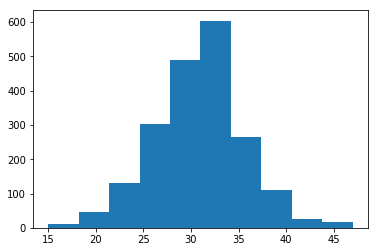

In [293]:
plt.hist(toRet[6][2])

In [286]:
import pickle
with open('test.pickle','wb') as f:
    pickle.dump(toRet,f, protocol = 0)

In [274]:
%%time
st = simTree(2312,1000)

Wall time: 5min 7s


In [275]:
stt = [len(e) for e in st]

In [280]:
pd.Series(stt).value_counts()

46    157
47    147
44    145
45    141
43    137
48    135
42    123
50    122
49    120
41    106
40    103
39     98
51     95
52     91
38     77
37     61
54     59
53     55
36     54
56     37
55     36
34     32
35     28
57     26
33     17
62     16
58     16
59     16
60     15
31     12
32      6
29      5
63      4
64      4
61      4
30      4
26      3
25      2
66      1
23      1
24      1
dtype: int64

(array([   7.,   21.,   83.,  393.,  511.,  580.,  483.,  158.,   51.,   25.]),
 array([ 23. ,  27.3,  31.6,  35.9,  40.2,  44.5,  48.8,  53.1,  57.4,
         61.7,  66. ]),
 <a list of 10 Patch objects>)

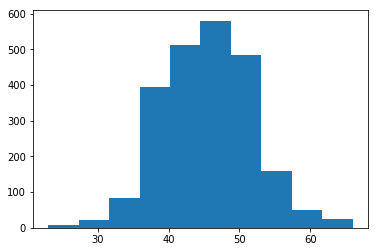

In [276]:
plt.hist(stt)

### Next Steps

It does look like there is some pattern to the rank-order an description date of the various taxa. The next thing to do will be to define and create metrics to more fully describe what those patterns are.  

Also, next it will be important to start to standardize and investigate the distriution of authorship.

split on space

In [151]:
for idx in df.index:
    au = df.loc[idx,'GAuthors']
    if au.count(' et al')>0:
        print(idx)
    #try:
     #   z = au.split(',')[1]
    #except:
    #    print(idx)

1150
2587
4552
4553
4554
4555
4958
4959
4960
4961
4962
4963
5104
5105
5703
8125
8126
8127
8128
8998
8999
10285


In [45]:
for idx in df.index:
    try:
        df.loc[idx,'SAuth'].split(',')[1]
    except:
        pass
        #print(idx)

#### Deprecated

In [20]:
df2 = pd.DataFrame(df.groupby(['SpG','Rank', 'DateRank',])['Species'].count())

In [676]:
df2.head()

Species
SpG Rank DateRank         
1   1    1             902
2   1    1             296
         2             104
    2    1             120
         2             280

In [243]:
SA = raw['SAuthors']
SAsp = pd.Series([authorSplit(e) for e in SA])
GA = raw['GAuthors']
GAsp = pd.Series([authorSplit(e) for e in GA])

In [244]:
sm = ['de','da','sr','la','le','jr','du','do','zu']
bef = ['zu','du', 'la'] #Du Bus de Gisignies, La Touche, Da Silva Maia
med = ['du', 'la'] # Barboza du Bocage, de la Llave, 
unk = ['do','le']
post = ['jr','sr']
test = ['da']

In [246]:
probs = []
for idx in GAsp.index:
    try:
        for n in GAsp[idx]:
            if n in sm:
                probs.append(idx)
    except:
        print('whoops', idx)
Ghard = list(raw.loc[probs,'GAuthors'].unique())
Ghard

['Le Maout',
 'Raposo do Amaral EtAl',
 'Du Bus de Gisignies',
 'zu Wied-Neuwied',
 'De Roo',
 'de la Llave',
 'De Vis',
 'de Sélys-Longchamps',
 'de Filippi']

In [247]:
for n in Ghard:
    if n not in hard:
        hard.append(n)

In [255]:
hard

['zu Wied-Neuwied',
 'Meyer de Schauensee',
 'Barboza du Bocage',
 'Meyer de Schauensee',
 'de Sélys-Longchamps',
 'Du Bus de Gisignies',
 'Gurney Sr',
 'de Sparre',
 'Gurney Jr',
 'Xántus de Vésey',
 'Da Silva Maia',
 'de la Llave',
 'de Filippi',
 'Phelps Jr',
 'Cardoso da Silva Novaes',
 'Wetmore Phelps Jr',
 'Giraud Jr',
 'De Vis',
 'De Roo',
 'La Touche',
 'Marshall JT Jr',
 'de Tarragon',
 'Phelps Jr',
 'Le Maout',
 'Raposo do Amaral']

In [46]:
speciesTree = {}
for o in soup.find_all('order'):
    oname = o.find('latin_name').text
    #print(oname)
    speciesTree[oname] = {}
    for f in o.find_all('family'):
        fname = f.find('latin_name').text
        #print(fname)
        speciesTree[oname][fname]= {}
        for g in f.find_all('genus'):
            gname = g.find('latin_name').text
            #print(gname)
            speciesTree[oname][fname][gname] = {'GAuthority': g.find('authority').text}
            for s in g.find_all('species'):
                sname = s.find('latin_name').text
                #print(sname)
                #print(s.find('authority').text)
                speciesTree[oname][fname][gname][sname] = {'SAuthourity': s.find('authority').text,
                                                           'Breeding' : s.find('breeding_regions').text}

In [595]:
tables = {}
currentSPG = 0
currentRank = 0
prevDR = 0
for idx in df2.index:
    if idx[0] >10:
        break
        
    spg = idx[0]
    rank = idx[1]
    dRank = idx[2]
    sp = df2.loc[idx, 'Species']
    
    if spg != currentSPG:
        tables[spg] = {}
        currentSPG = spg
        tables[spg][rank] = []
        currentRank = 1
        prevDR = 0
        
    if rank != currentRank: 
        tables[spg][rank] = []
        currentRank = rank
        prevDR = 0
    
    if prevDR +1 != dRank:
        for i in range(dRank-prevDR-1):
            
            tables[spg][rank].append(0)
    
    tables[spg][rank].append(sp)
    prevDR = dRank

    tables    

1 0 1
2 0 1
2 1 2
2 0 1
2 1 2
3 0 1
3 1 2
3 2 3
3 0 1
3 1 2
3 2 3
3 0 1
3 1 2
3 2 3
4 0 1
4 1 2
4 2 3
4 3 4
4 0 1
4 1 2
4 2 3
4 3 4
4 0 1
4 1 2
4 2 3
4 3 4
4 0 1
4 1 2
4 2 3
4 3 4
5 0 1
5 1 2
5 2 3
5 3 4
5 4 5
5 0 1
5 1 2
5 2 3
5 3 4
5 4 5
5 0 1
5 1 2
5 2 3
5 3 4
5 4 5
5 0 1
5 1 2
5 2 3
5 3 4
5 4 5
5 0 1
5 1 2
5 2 3
5 3 4
5 4 5
6 0 1
6 1 2
6 2 3
6 3 4
6 4 5
6 5 6
6 0 1
6 1 2
6 2 3
6 3 4
6 4 5
6 5 6
6 0 1
6 1 2
6 2 3
6 3 4
6 4 5
6 5 6
6 0 1
6 1 2
6 2 3
6 3 4
6 4 5
6 5 6
6 0 1
6 1 2
6 2 3
6 3 4
6 4 5
6 5 6
6 0 1
6 1 2
6 2 3
6 3 4
6 4 5
6 5 6
7 0 1
7 1 2
7 2 3
7 3 4
7 4 5
7 5 6
7 6 7
7 0 1
7 1 2
7 2 3
7 3 4
7 4 5
7 5 6
7 6 7
7 0 1
7 1 2
7 2 3
7 3 4
7 4 5
7 5 6
7 6 7
7 0 1
7 1 2
7 2 3
7 3 4
7 4 5
7 5 6
7 6 7
7 0 1
7 1 2
7 2 3
7 3 4
7 4 5
7 5 6
7 6 7
7 0 1
7 1 2
7 2 3
7 3 4
7 4 5
7 5 6
7 6 7
7 0 1
7 1 2
7 2 3
7 3 4
7 4 5
7 5 6
7 6 7
8 0 1
8 1 2
8 2 3
8 3 4
8 4 5
8 5 6
8 6 7
8 7 8
8 0 1
8 1 2
8 2 3
8 3 4
8 4 5
8 5 6
8 6 7
8 7 8
8 0 1
8 1 2
8 2 3
8 3 4
8 4 5
8 5 6
8 6 7
8 7 8
8 0 1
8 1 2
8 2 

In [84]:
locs = {1:(1,1),2:(1,2),3:(1,4),4:(1,7),5:(1,11),6:(1,16),7:(7,15),8:(6,1),9:(15,1),10:(14,12)}
plt.figure(figsize = (20,20))
i = 0
for k in tables:
    i+=1
    
    temp = pd.DataFrame(tables[k])
    temp.index = range(1,len(temp)+1)
    for c in temp:
        temp[c] = [e/temp[c].sum()/(1/len(temp)) for e in temp[c]]
    where = locs[i]
    pltNum = where[0]*21+where[1]
    plt.subplot2grid((23,21),(where[0]-1, where[1]-1),colspan = i, rowspan = i)
    sns.heatmap(temp, annot = True, cmap = 'coolwarm', center = 1,square = True, cbar = False)
plt.subplot2grid((23,21),(5,8), colspan = 5, rowspan = 5)

plt.xlabel('hi')
plt.ylabel('no')
plt.axis('equal')
plt.axis('off')
plt.text(-0.05,-0.01,'species Rank', rotation = 'vertical', fontsize = 28)#, horizontalalignment = 'right')
plt.text(-0.036,-0.08,'Date Rank', rotation = 'horizontal', fontsize = 24)#, horizontalalignment = 'left')
plt.text(0.009,0.00,'Proportion\n of\n species', fontsize = 30, horizontalalignment = 'center')
#plt.title('yup')

NameError: name 'tables' is not defined